 Load packages used for the project

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path
import imageio
import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow

In [2]:
IMAGE_PATH = '../input/bee_imgs/bee_imgs/'
IMAGE_WIDTH = 100
IMAGE_HEIGHT = 100
IMAGE_CHANNELS = 3
RANDOM_STATE = 2018
TEST_SIZE = 0.2
VAL_SIZE = 0.2
CONV_2D_DIM_1 = 16
CONV_2D_DIM_2 = 16
CONV_2D_DIM_3 = 32
CONV_2D_DIM_4 = 64
MAX_POOL_DIM = 2
KERNEL_SIZE = 3
BATCH_SIZE = 32
NO_EPOCHS_1 = 5
NO_EPOCHS_2 = 10
NO_EPOCHS_3 = 50
PATIENCE = 5
VERBOSE = 1

In [3]:
os.listdir("D:/ULKA/MIT sem 5/application ai/miniproject/input")

['bee_data.csv', 'bee_imgs']

In [4]:
honey_bee_df=pd.read_csv('D:/ULKA/MIT sem 5/application ai/miniproject/input/bee_data.csv')
honey_bee_df.shape
honey_bee_df.sample(100).head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
1923,040_319.png,8/21/18,15:56,"Athens, GA, USA",30607,Italian honey bee,"few varrao, hive beetles",False,worker
1852,040_109.png,8/21/18,15:56,"Athens, GA, USA",30607,Italian honey bee,"few varrao, hive beetles",False,worker
3984,032_412.png,8/21/18,9:00,"Des Moines, IA, USA",50315,Russian honey bee,healthy,False,worker
829,030_606.png,8/17/18,17:50,"Alvin, TX, USA",77511,Italian honey bee,ant problems,False,worker
4038,032_548.png,8/21/18,9:00,"Des Moines, IA, USA",50315,Russian honey bee,healthy,False,worker


In [5]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data(honey_bee_df)

,Total,Percent
file,0,0.0
date,0,0.0
time,0,0.0
location,0,0.0
zip code,0,0.0
subspecies,0,0.0
health,0,0.0
pollen_carrying,0,0.0
caste,0,0.0


In [6]:
IMAGE_PATH = 'D:/ULKA/MIT sem 5/application ai/miniproject/input/bee_imgs/bee_imgs/'
image_files = list(os.listdir(IMAGE_PATH))
print("Number of image files: {}".format(len(image_files)))

Number of image files: 5173


In [7]:
tmp = honey_bee_df.groupby(['zip code'])['location'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
df

,zip code,location,Images
0,3431,"Keene, NH, USA",92
1,30607,"Athens, GA, USA",579
2,30607,"Athens, Georgia, USA",472
3,50315,"Des Moines, IA, USA",973
4,70115,"New Orleans, LA, USA",170
5,77511,"Alvin, TX, USA",737
6,95070,"Saratoga, CA, USA",2000
7,95124,"San Jose, CA, USA",149


In [8]:
honey_bee_df = honey_bee_df.replace({'location':'Athens, Georgia, USA'}, 'Athens, GA, USA')

In [9]:
tmp = honey_bee_df.groupby(['zip code'])['location'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
df['code'] = df['location'].map(lambda x: x.split(',', 2)[1])
df

,zip code,location,Images,code
0,3431,"Keene, NH, USA",92,NH
1,30607,"Athens, GA, USA",1051,GA
2,50315,"Des Moines, IA, USA",973,IA
3,70115,"New Orleans, LA, USA",170,LA
4,77511,"Alvin, TX, USA",737,TX
5,95070,"Saratoga, CA, USA",2000,CA
6,95124,"San Jose, CA, USA",149,CA


In [10]:
trace = go.Bar(
        x = df['location'],
        y = df['Images'],
        marker=dict(color="Tomato"),
        text=df['location']
    )
data = [trace]
    
layout = dict(title = 'Number of bees images per location',
          xaxis = dict(title = 'Subspecies', showticklabels=True, tickangle=15), 
          yaxis = dict(title = 'Number of images'),
          hovermode = 'closest'
         )
fig = dict(data = data, layout = layout)
iplot(fig, filename='images-location')

In [11]:
locations = (honey_bee_df.groupby(['location'])['location'].nunique()).index
print(locations)

Index(['Alvin, TX, USA', 'Athens, GA, USA', 'Des Moines, IA, USA',
       'Keene, NH, USA', 'New Orleans, LA, USA', 'San Jose, CA, USA',
       'Saratoga, CA, USA'],
      dtype='object', name='location')


In [12]:
def draw_category_images(var,cols=5):
    categories = (honey_bee_df.groupby([var])[var].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=cols, figsize=(2*cols,2*len(categories)))
    for i, cat in enumerate(categories):
        sample = honey_bee_df[honey_bee_df[var]==cat].sample(cols)
        for j in range(0,cols):
            file=IMAGE_PATH + sample.iloc[j]['file']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True)
            ax[i, j].set_title(cat, fontsize=9)  
    plt.tight_layout()
    plt.show()

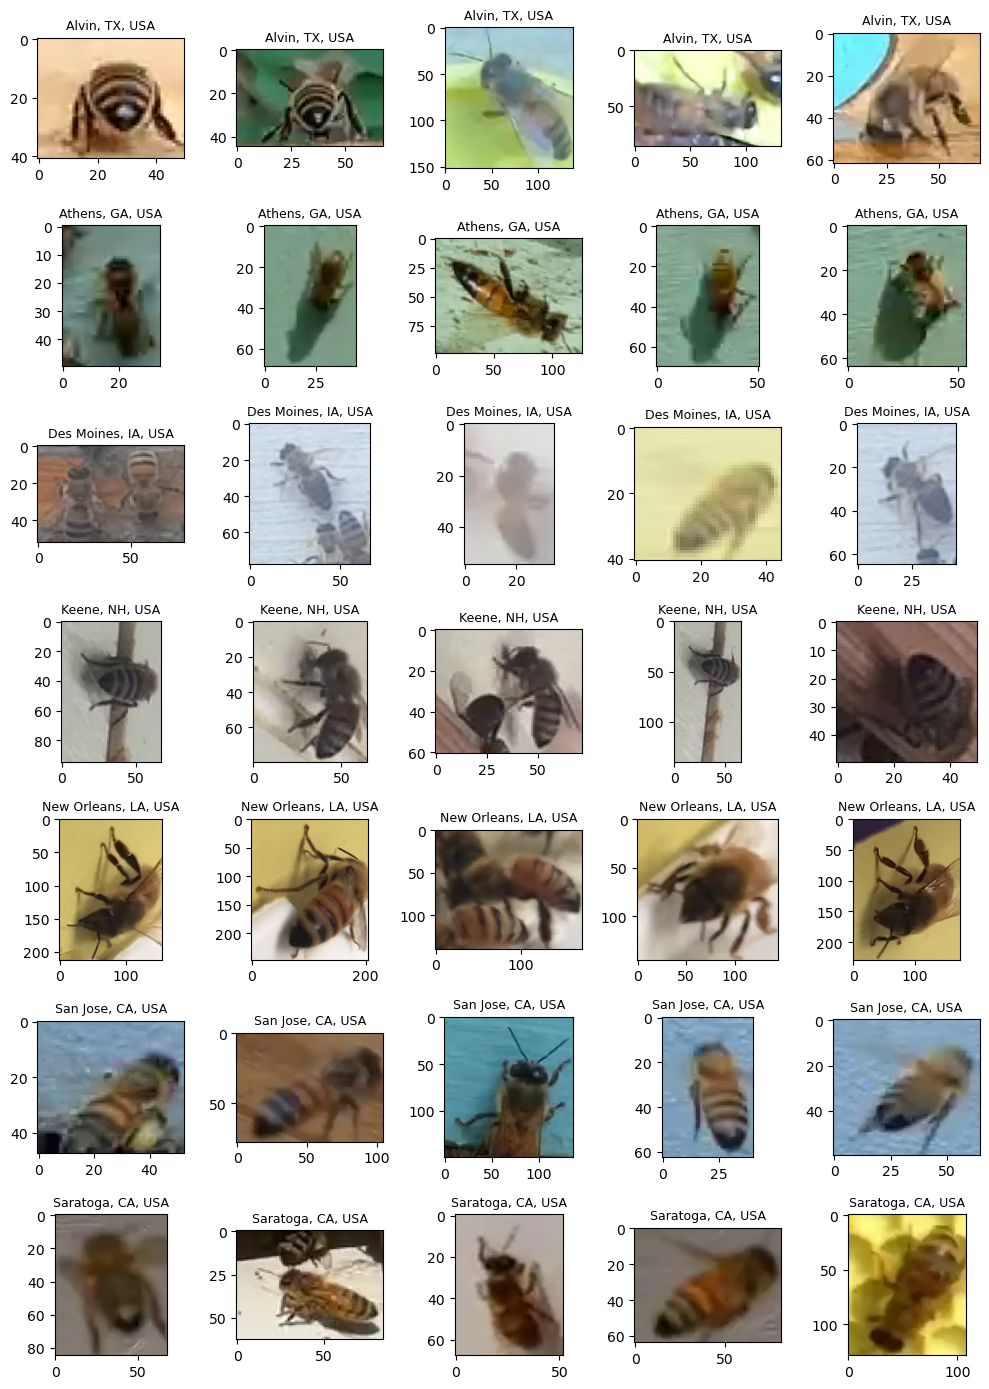

In [13]:
draw_category_images("location")

In [14]:
honey_bee_df['date_time'] = pd.to_datetime(honey_bee_df['date'] + ' ' + honey_bee_df['time'])
honey_bee_df["year"] = honey_bee_df['date_time'].dt.year
honey_bee_df["month"] = honey_bee_df['date_time'].dt.month
honey_bee_df["day"] = honey_bee_df['date_time'].dt.day
honey_bee_df["hour"] = honey_bee_df['date_time'].dt.hour
honey_bee_df["minute"] = honey_bee_df['date_time'].dt.minute

In [15]:
tmp = honey_bee_df.groupby(['date_time', 'hour'])['location'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
hover_text = []
for index, row in df.iterrows():
    hover_text.append(('Date/time: {}<br>'+
                      'Hour: {}<br>'+
                      'Location: {}<br>'+
                      'Images: {}').format(row['date_time'],
                                            row['hour'],
                                            row['location'],
                                            row['Images']))
df['hover_text'] = hover_text
locations = (honey_bee_df.groupby(['location'])['location'].nunique()).index
data = []
for location in locations:
    dfL = df[df['location']==location]
    trace = go.Scatter(
        x = dfL['date_time'],y = dfL['hour'],
        name=location,
        marker=dict(
            symbol='circle',
            sizemode='area',
            sizeref=0.2,
            size=dfL['Images'],
            line=dict(
                width=2
            ),),
        mode = "markers",
        text=dfL['hover_text'],
    )
    data.append(trace)
    
layout = dict(title = 'Number of bees images per date, approx. hour and location',
          xaxis = dict(title = 'Date', showticklabels=True), 
          yaxis = dict(title = 'Hour'),
          hovermode = 'closest'
         )
fig = dict(data = data, layout = layout)

iplot(fig, filename='images-date_time')

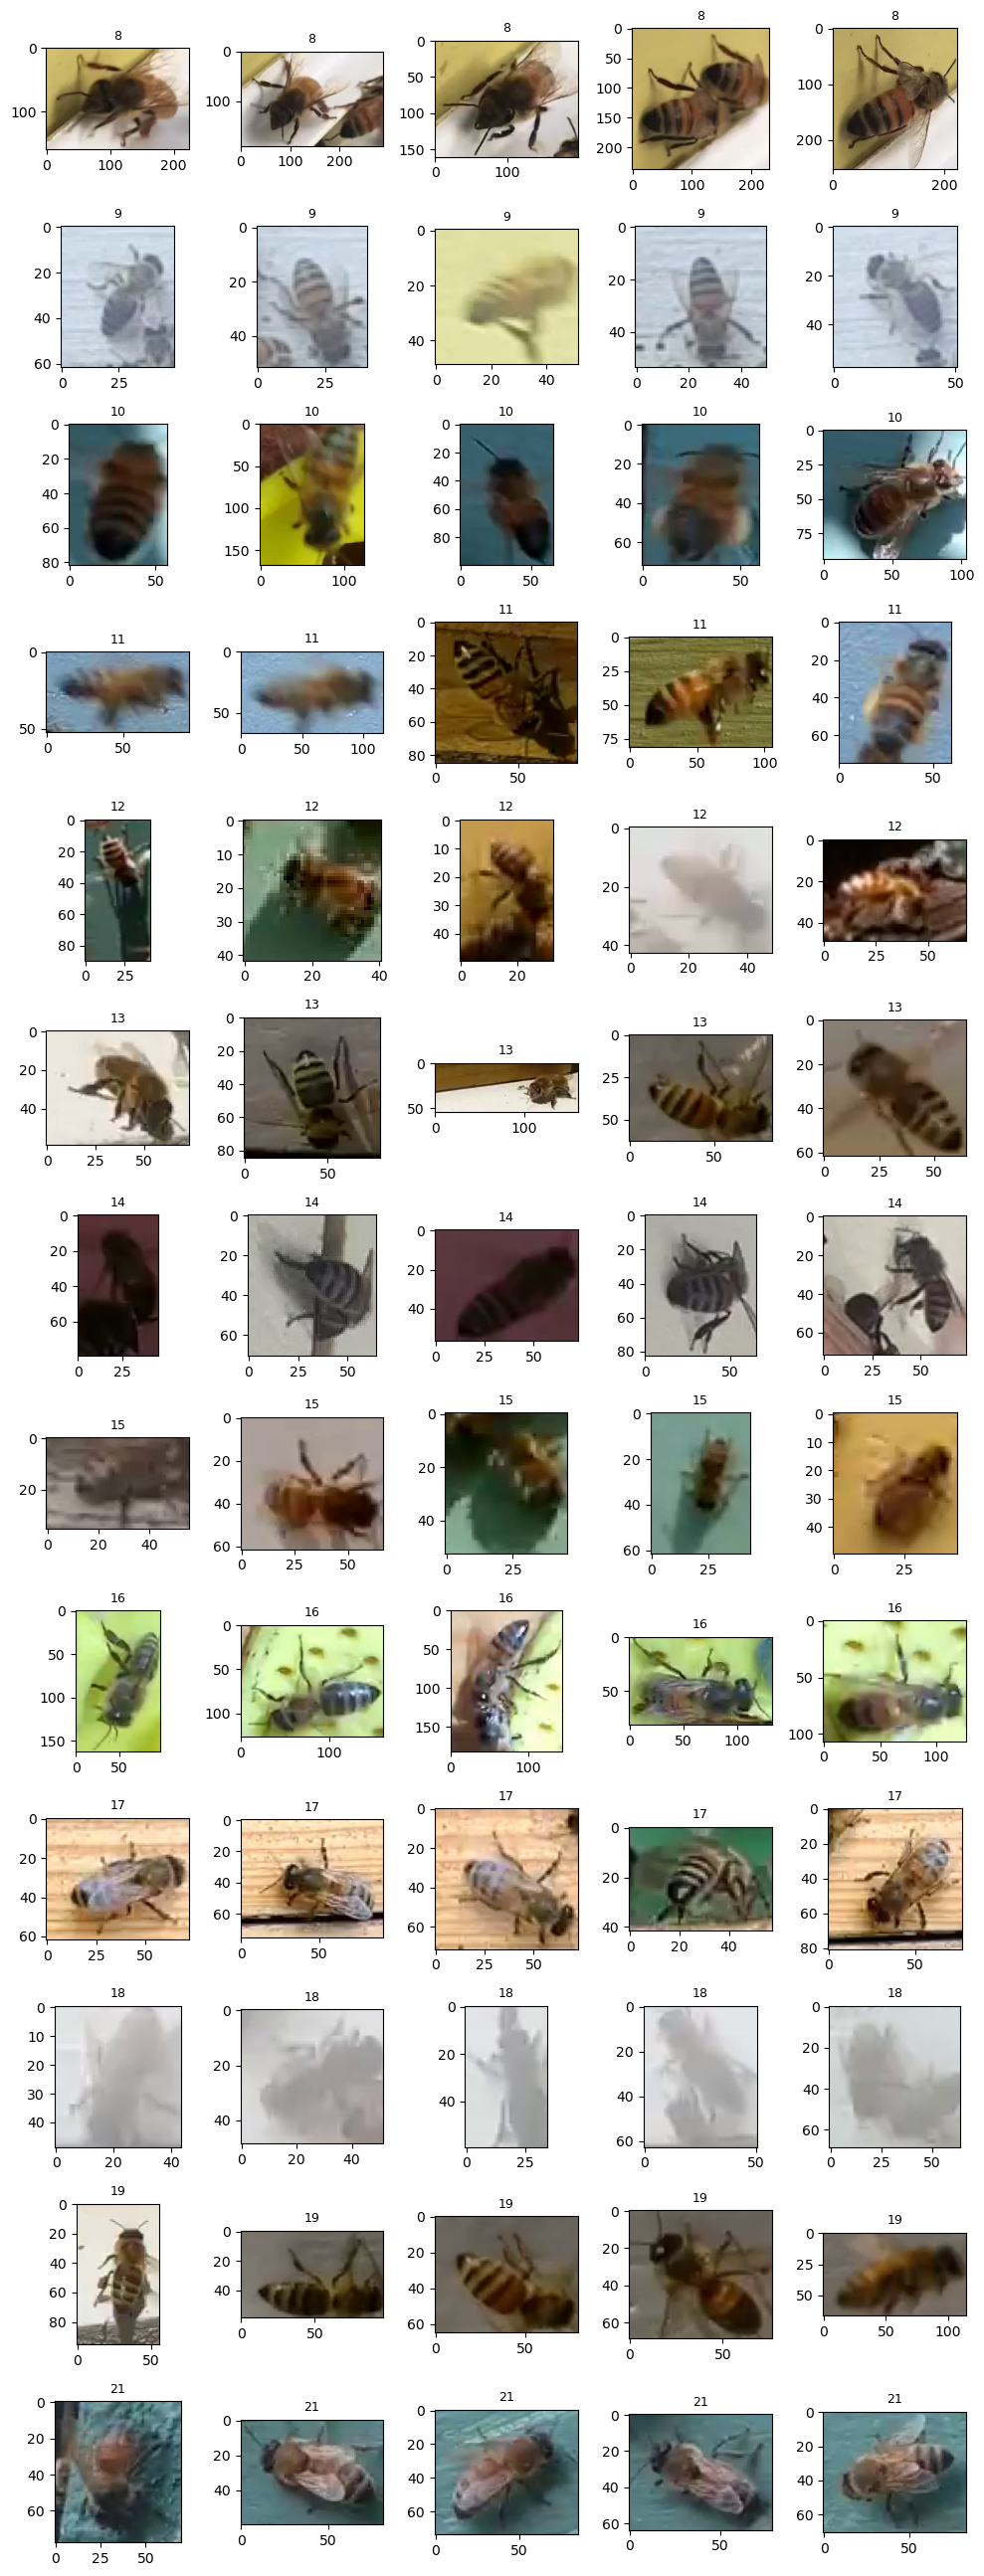

In [16]:
draw_category_images("hour")

In [17]:
tmp = honey_bee_df.groupby(['subspecies'])['year'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
df

,subspecies,year,Images
0,-1,2018,428
1,1 Mixed local stock 2,2018,472
2,Carniolan honey bee,2018,501
3,Italian honey bee,2018,3008
4,Russian honey bee,2018,527
5,VSH Italian honey bee,2018,199
6,Western honey bee,2018,37


In [18]:
trace = go.Bar(
        x = df['subspecies'],
        y = df['Images'],
        marker=dict(color="Green"),
        text=df['subspecies']
    )
data = [trace]
    
layout = dict(title = 'Number of bees images per subspecies',
          xaxis = dict(title = 'Subspecies', showticklabels=True, tickangle=15), 
          yaxis = dict(title = 'Number of images'),
          hovermode = 'closest'
         )
fig = dict(data = data, layout = layout)
iplot(fig, filename='images-subspecies')

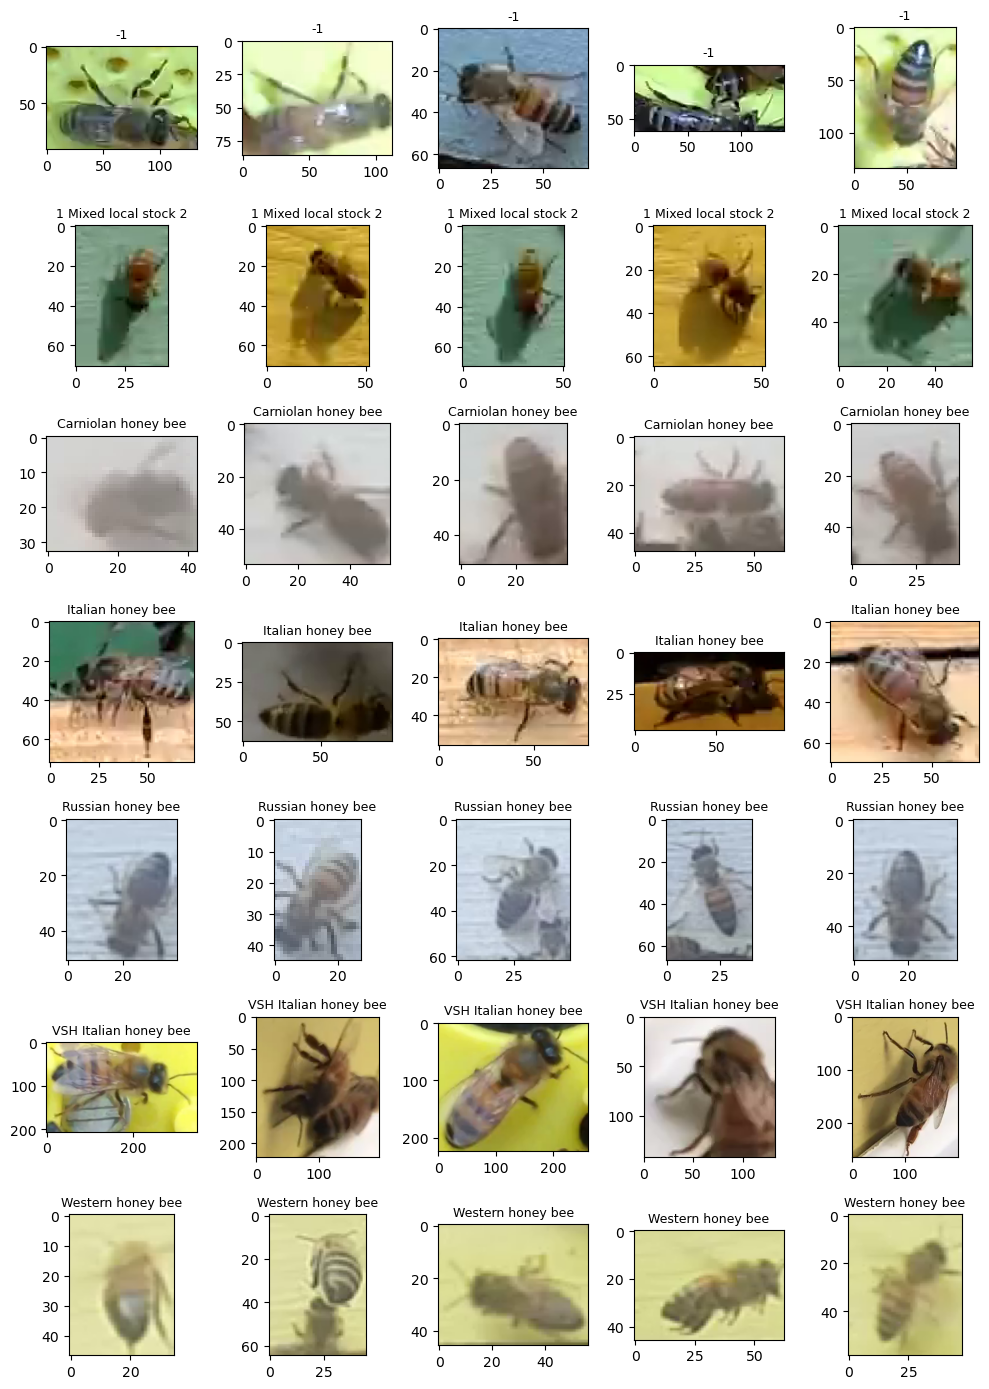

In [19]:
draw_category_images("subspecies")

In [20]:
train_df, test_df = train_test_split(honey_bee_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=honey_bee_df['subspecies'])

In [21]:
train_df, val_df = train_test_split(train_df, test_size=VAL_SIZE, random_state=RANDOM_STATE, stratify=train_df['subspecies'])

In [22]:
print("Train set rows: {}".format(train_df.shape[0]))
print("Test  set rows: {}".format(test_df.shape[0]))
print("Val   set rows: {}".format(val_df.shape[0]))

Train set rows: 3309
Test  set rows: 1035
Val   set rows: 828


In [23]:
def read_image(file_name):
    image = skimage.io.imread(IMAGE_PATH + file_name)
    image = skimage.transform.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), mode='reflect')
    return image[:,:,:IMAGE_CHANNELS]

In [24]:
def categories_encoder(dataset, var='subspecies'):
    X = np.stack(dataset['file'].apply(read_image))
    y = pd.get_dummies(dataset[var], drop_first=False)
    return X, y

In [25]:
X_train, y_train = categories_encoder(train_df)
X_val, y_val = categories_encoder(val_df)
X_test, y_test = categories_encoder(test_df)

In [26]:
model1=Sequential()
model1.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model1.add(MaxPool2D(MAX_POOL_DIM))
model1.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model1.add(Flatten())
model1.add(Dense(y_train.columns.size, activation='softmax'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 16)        2320      
                                                                 
 flatten (Flatten)           (None, 40000)             0         
                                                                 
 dense (Dense)               (None, 7)                 280007    
                                                                 
Total params: 282775 (1.08 MB)
Trainable params: 282775 (1.08 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [28]:
image_generator = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=180,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True,
        vertical_flip=True)
image_generator.fit(X_train)

In [29]:
train_model1  = model1.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                        epochs=NO_EPOCHS_1,
                        validation_data=[X_val, y_val],
                        steps_per_epoch=len(X_train)/BATCH_SIZE)

C:\Users\ulkam\AppData\Local\Temp\ipykernel_1116\3007739634.py:1: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/5


103/103 [==============================] - 18s 141ms/step - loss: 0.8306 - accuracy: 0.7153 - val_loss: 0.6689 - val_accuracy: 0.7621
Epoch 2/5
103/103 [==============================] - 14s 138ms/step - loss: 0.5247 - accuracy: 0.8002 - val_loss: 0.4869 - val_accuracy: 0.8406
Epoch 3/5
103/103 [==============================] - 14s 135ms/step - loss: 0.4033 - accuracy: 0.8362 - val_loss: 0.3664 - val_accuracy: 0.8321
Epoch 4/5
103/103 [==============================] - 15s 148ms/step - loss: 0.3664 - accuracy: 0.8555 - val_loss: 0.3322 - val_accuracy: 0.8659
Epoch 5/5
103/103 [==============================] - 14s 134ms/step - loss: 0.3182 - accuracy: 0.8664 - val_loss: 0.3095 - val_accuracy: 0.8647


In [30]:
#Code for creating plot only nothing related to training

def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
    
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    #define the traces
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    #add traces to the figure
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    #set the layout for the figure
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])
    #plot
    iplot(fig, filename='accuracy-loss')

plot_accuracy_and_loss(train_model1)

In [31]:
score = model1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.30969613790512085
Test accuracy: 0.8743961453437805


In [32]:
def test_accuracy_report(model):
    predicted = model.predict(X_test)
    test_predicted = np.argmax(predicted, axis=1)
    test_truth = np.argmax(y_test.values, axis=1)
    print(metrics.classification_report(test_truth, test_predicted, target_names=y_test.columns)) 
    test_res = model.evaluate(X_test, y_test.values, verbose=0)
    print('Loss function: %s, accuracy:' % test_res[0], test_res[1])

In [33]:
test_accuracy_report(model1)

33/33 [==============================] - 1s 12ms/step
                       precision    recall  f1-score   support

                   -1       0.97      0.70      0.81        86
1 Mixed local stock 2       0.55      0.73      0.63        94
  Carniolan honey bee       0.92      1.00      0.96       100
    Italian honey bee       0.91      0.90      0.91       602
    Russian honey bee       0.92      0.96      0.94       106
VSH Italian honey bee       0.93      0.62      0.75        40
    Western honey bee       1.00      1.00      1.00         7

             accuracy                           0.87      1035
            macro avg       0.88      0.85      0.86      1035
         weighted avg       0.89      0.87      0.88      1035

Loss function: 0.30969613790512085, accuracy: 0.8743961453437805


In [34]:
model2=Sequential()
model2.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model2.add(MaxPool2D(MAX_POOL_DIM))
# Add dropouts to the model
model2.add(Dropout(0.4))
model2.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
# Add dropouts to the model
model2.add(Dropout(0.4))
model2.add(Flatten())
model2.add(Dense(y_train.columns.size, activation='softmax'))
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 50, 50, 16)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 50, 50, 16)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 16)        2320      
                                                                 
 dropout_1 (Dropout)         (None, 50, 50, 16)        0         
                                                                 
 flatten_1 (Flatten)         (None, 40000)             0         
                                                      

In [36]:
train_model2  = model2.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                        epochs=NO_EPOCHS_2,
                        validation_data=[X_val, y_val],
                        steps_per_epoch=len(X_train)/BATCH_SIZE)

Epoch 1/10


C:\Users\ulkam\AppData\Local\Temp\ipykernel_1116\2538114789.py:1: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



103/103 [==============================] - 19s 176ms/step - loss: 1.1032 - accuracy: 0.6467 - val_loss: 0.7406 - val_accuracy: 0.7307
Epoch 2/10
103/103 [==============================] - 18s 170ms/step - loss: 0.7361 - accuracy: 0.7341 - val_loss: 0.6953 - val_accuracy: 0.7403
Epoch 3/10
103/103 [==============================] - 18s 170ms/step - loss: 0.5682 - accuracy: 0.7827 - val_loss: 0.5054 - val_accuracy: 0.7983
Epoch 4/10
103/103 [==============================] - 18s 170ms/step - loss: 0.4484 - accuracy: 0.8211 - val_loss: 0.4468 - val_accuracy: 0.8043
Epoch 5/10
103/103 [==============================] - 19s 188ms/step - loss: 0.4063 - accuracy: 0.8335 - val_loss: 0.3877 - val_accuracy: 0.8297
Epoch 6/10
103/103 [==============================] - 18s 171ms/step - loss: 0.3902 - accuracy: 0.8444 - val_loss: 0.3629 - val_accuracy: 0.8539
Epoch 7/10
103/103 [==============================] - 18s 171ms/step - loss: 0.3493 - accuracy: 0.8522 - val_loss: 0.3299 - val_accuracy: 0.8

In [37]:
plot_accuracy_and_loss(train_model2)

In [38]:
test_accuracy_report(model2)

33/33 [==============================] - 0s 12ms/step
                       precision    recall  f1-score   support

                   -1       0.90      0.73      0.81        86
1 Mixed local stock 2       0.53      0.84      0.65        94
  Carniolan honey bee       0.82      0.99      0.90       100
    Italian honey bee       0.96      0.84      0.90       602
    Russian honey bee       0.89      0.96      0.92       106
VSH Italian honey bee       0.77      0.82      0.80        40
    Western honey bee       0.88      1.00      0.93         7

             accuracy                           0.86      1035
            macro avg       0.82      0.88      0.84      1035
         weighted avg       0.89      0.86      0.87      1035

Loss function: 0.3507259488105774, accuracy: 0.8599033951759338


In [39]:
annealer3 = LearningRateScheduler(lambda x: 1e-3 * 0.995 ** (x+NO_EPOCHS_3))
earlystopper3 = EarlyStopping(monitor='loss', patience=PATIENCE, verbose=VERBOSE)
checkpointer3 = ModelCheckpoint('best_model_3.h5',
                                monitor='val_acc',
                                verbose=VERBOSE,
                                save_best_only=True,
                                save_weights_only=True)

In [40]:
model3=Sequential()
model3.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model3.add(MaxPool2D(MAX_POOL_DIM))
model3.add(Dropout(0.4))
model3.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model3.add(Dropout(0.4))
model3.add(Flatten())
model3.add(Dense(y_train.columns.size, activation='softmax'))
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 50, 50, 16)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 50, 50, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 50, 50, 16)        2320      
                                                                 
 dropout_3 (Dropout)         (None, 50, 50, 16)        0         
                                                                 
 flatten_2 (Flatten)         (None, 40000)             0         
                                                      

In [42]:
train_model3  = model3.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                        epochs=NO_EPOCHS_3,
                        validation_data=[X_val, y_val],
                        steps_per_epoch=len(X_train)/BATCH_SIZE,
                        callbacks=[earlystopper3, checkpointer3, annealer3])

Epoch 1/50


C:\Users\ulkam\AppData\Local\Temp\ipykernel_1116\2443815439.py:1: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



103/103 [==============================] - 19s 175ms/step - loss: 1.2291 - accuracy: 0.6216 - val_loss: 1.1067 - val_accuracy: 0.7440 - lr: 7.7831e-04
Epoch 2/50
103/103 [==============================] - 18s 172ms/step - loss: 0.8244 - accuracy: 0.7044 - val_loss: 0.6693 - val_accuracy: 0.7440 - lr: 7.7442e-04
Epoch 3/50
103/103 [==============================] - 18s 172ms/step - loss: 0.6158 - accuracy: 0.7661 - val_loss: 0.5402 - val_accuracy: 0.7814 - lr: 7.7055e-04
Epoch 4/50
103/103 [==============================] - 18s 172ms/step - loss: 0.4770 - accuracy: 0.8150 - val_loss: 0.4688 - val_accuracy: 0.7862 - lr: 7.6670e-04
Epoch 5/50
103/103 [==============================] - 18s 171ms/step - loss: 0.4336 - accuracy: 0.8193 - val_loss: 0.4076 - val_accuracy: 0.8345 - lr: 7.6286e-04
Epoch 6/50
103/103 [==============================] - 18s 171ms/step - loss: 0.4032 - accuracy: 0.8386 - val_loss: 0.4064 - val_accuracy: 0.8188 - lr: 7.5905e-04
Epoch 7/50
103/103 [===================

In [43]:
plot_accuracy_and_loss(train_model3)

In [44]:
test_accuracy_report(model3)

33/33 [==============================] - 0s 12ms/step
                       precision    recall  f1-score   support

                   -1       0.99      0.77      0.86        86
1 Mixed local stock 2       0.51      0.87      0.65        94
  Carniolan honey bee       0.84      1.00      0.91       100
    Italian honey bee       0.95      0.87      0.91       602
    Russian honey bee       0.99      0.83      0.90       106
VSH Italian honey bee       0.97      0.88      0.92        40
    Western honey bee       0.70      1.00      0.82         7

             accuracy                           0.87      1035
            macro avg       0.85      0.89      0.85      1035
         weighted avg       0.90      0.87      0.88      1035

Loss function: 0.2799786329269409, accuracy: 0.8714975714683533
